In [1]:
import numpy as np
import cifar10
import matplotlib.pyplot as plt
import cv2
from skimage import color
from tqdm import tqdm

In [2]:
cifar10.data_path = "data/CIFAR-10/"

In [3]:
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [4]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
images_train, cls_train, labels_train = cifar10.load_training_data()
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [6]:
images_train.shape

(50000, 32, 32, 3)

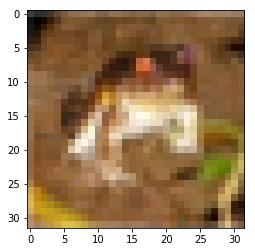

In [7]:
from skimage.exposure import adjust_sigmoid as adjust
from skimage.segmentation import slic
gray = images_train[0]#color.rgb2gray(images_train[0])
plt.imshow(gray) #(gray, cmap = 'gray')
plt.show()

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from skimage.transform import downscale_local_mean
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA


In [9]:
gray_train = []
for i in tqdm(range(images_train.shape[0])):
    gray = images_train[i] #color.rgb2gray(images_train[i])
    adj = adjust(gray)
    adj = adjust(adj)
    small = downscale_local_mean(gray, (1, 1, 1))
    #small = downscale_local_mean(gray, (1, 1, 3))
    #small = downscale_local_mean(gray, (2, 2, 3))
    gray_train.append(small)
gray_train = np.array(gray_train)
gray_train.shape

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:22<00:00, 2244.16it/s]


(50000, 32, 32, 3)

In [10]:
gray_test = []
for i in tqdm(range(images_test.shape[0])):
    gray = images_test[i]#color.rgb2gray(images_test[i])
    small = downscale_local_mean(gray, (1, 1, 1))
    #small = downscale_local_mean(gray, (1, 1, 3))
    #small = downscale_local_mean(gray, (2, 2, 3))
    gray_test.append(small)
gray_test = np.array(gray_test)
gray_test.shape

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2968.22it/s]


(10000, 32, 32, 3)

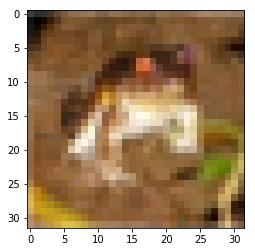

In [11]:
gray = gray_train.reshape(-1, 32, 32, 3)[0]
plt.imshow(gray, cmap = 'gray')
plt.show()

In [12]:
del images_train, images_test

In [13]:
gray_train = gray_train.reshape(-1, 32 * 32 * 3)
gray_test = gray_test.reshape(-1, 32 * 32 * 3)

In [14]:
gray_test.shape

(10000, 3072)

In [15]:
gray_train.shape

(50000, 3072)

In [16]:
scaler = StandardScaler()

In [17]:
pca = PCA(n_components=658, whiten=True)
k_pca = KernelPCA(kernel='rbf', n_components=658)
i_pca = IncrementalPCA(n_components=658, whiten=True)

In [19]:
import time
st = time.time()
X_train_pca = pca.fit_transform(gray_train)
et = time.time()
round(et-st, 2)

0.0

In [ ]:
st = time.time()
X_train_k_pca = k_pca.fit_transform(gray_train)
et = time.time()
round(et-st, 2)

In [20]:
st = time.time()
X_train_i_pca = i_pca.fit_transform(gray_train)
et = time.time()
round(et-st, 2)

187.48

In [ ]:
st = time.time()
X_test_pca = pca.transform(gray_test)
et = time.time()
round(et-st, 2)

In [ ]:
st = time.time()
X_test_k_pca = k_pca.transform(gray_test)
et = time.time()
round(et-st, 2)

In [21]:
st = time.time()
X_test_i_pca = i_pca.transform(gray_test)
et = time.time()
round(et-st, 2)

1.14

In [28]:
st = time.time()
X_train_chosen = X_train_i_pca[:, :100]
X_test_chosen = X_test_i_pca[:, :100]
X_train = scaler.fit_transform(X_train_chosen)
X_test = scaler.transform(X_test_chosen)
et = time.time()
round(et-st, 2)

1.49

In [ ]:
base_clf = RandomForestClassifier(n_estimators=50, verbose=1)
clf = BaggingClassifier(base_estimator=base_clf, n_jobs=2, verbose=2, n_estimators=20) #AdaBoostClassifier(verbose=1, base_estimator=base_clf, n_estimators=10)
#clf = RandomForestClassifier(n_estimators=20, verbose=2)
#clf = RandomForestClassifier(n_estimators=1000, max_depth=20, min_samples_split = 10, verbose=2)
#clf = LogisticRegression(solver='sag')
clf.fit(X_train, cls_train)
print(clf.score(X_train, cls_train), clf.score(X_test, cls_test))

In [82]:
#clf = RandomForestClassifier(n_estimators=50, max_depth=20, min_samples_split = 10, verbose=1)
"""
param_grid = {
    'C' : [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
    'gamma' : [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
    'max_iter' :[10]
    'kernel' :
}

"""

param_grid = {
    'C' : [1e-2, 1e-1, 1],
    'gamma' : [1e-1, 1],
    'max_iter' :[10],
    'kernel' : ['rbf', 'sigmoid'],
    'random_state' : [0],
}

clf = GridSearchCV(estimator=SVC(), param_grid=param_grid, verbose=3)
clf.fit(X_train, cls_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] C=0.01, gamma=0.1, kernel=rbf, max_iter=10, random_state=0 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.1, kernel=rbf, max_iter=10, random_state=0, score=0.1116376724655069, total=   7.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.9s remaining:    0.0s


[CV] C=0.01, gamma=0.1, kernel=rbf, max_iter=10, random_state=0 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.1, kernel=rbf, max_iter=10, random_state=0, score=0.10941811637672466, total=   7.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.2s remaining:    0.0s


[CV] C=0.01, gamma=0.1, kernel=rbf, max_iter=10, random_state=0 ......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.1, kernel=rbf, max_iter=10, random_state=0, score=0.1131452581032413, total=   8.2s
[CV] C=0.01, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0 ..


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0, score=0.11655668866226755, total=   9.4s
[CV] C=0.01, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0 ..


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0, score=0.10815836832633473, total=   9.5s
[CV] C=0.01, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0 ..


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0, score=0.11980792316926771, total=   9.4s
[CV] C=0.01, gamma=1, kernel=rbf, max_iter=10, random_state=0 ........


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=1, kernel=rbf, max_iter=10, random_state=0, score=0.16490701859628074, total=   4.4s
[CV] C=0.01, gamma=1, kernel=rbf, max_iter=10, random_state=0 ........


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=1, kernel=rbf, max_iter=10, random_state=0, score=0.1617876424715057, total=   4.4s
[CV] C=0.01, gamma=1, kernel=rbf, max_iter=10, random_state=0 ........


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=1, kernel=rbf, max_iter=10, random_state=0, score=0.12599039615846339, total=   4.8s
[CV] C=0.01, gamma=1, kernel=sigmoid, max_iter=10, random_state=0 ....


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=1, kernel=sigmoid, max_iter=10, random_state=0, score=0.11481703659268146, total=   8.9s
[CV] C=0.01, gamma=1, kernel=sigmoid, max_iter=10, random_state=0 ....


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=1, kernel=sigmoid, max_iter=10, random_state=0, score=0.10743851229754049, total=   8.9s
[CV] C=0.01, gamma=1, kernel=sigmoid, max_iter=10, random_state=0 ....


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.01, gamma=1, kernel=sigmoid, max_iter=10, random_state=0, score=0.11998799519807923, total=   8.8s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=10, random_state=0 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=10, random_state=0, score=0.1137372525494901, total=   7.2s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=10, random_state=0 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=10, random_state=0, score=0.10827834433113377, total=   7.3s
[CV] C=0.1, gamma=0.1, kernel=rbf, max_iter=10, random_state=0 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.1, kernel=rbf, max_iter=10, random_state=0, score=0.11896758703481393, total=   7.6s
[CV] C=0.1, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0 ...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0, score=0.11655668866226755, total=   9.4s
[CV] C=0.1, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0 ...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0, score=0.1098380323935213, total=   9.5s
[CV] C=0.1, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0 ...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0, score=0.11980792316926771, total=   9.5s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=10, random_state=0 .........


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=10, random_state=0, score=0.1698860227954409, total=   4.4s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=10, random_state=0 .........


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=10, random_state=0, score=0.1569886022795441, total=   4.4s
[CV] C=0.1, gamma=1, kernel=rbf, max_iter=10, random_state=0 .........


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1, kernel=rbf, max_iter=10, random_state=0, score=0.11746698679471788, total=   4.9s
[CV] C=0.1, gamma=1, kernel=sigmoid, max_iter=10, random_state=0 .....


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1, kernel=sigmoid, max_iter=10, random_state=0, score=0.11481703659268146, total=   8.9s
[CV] C=0.1, gamma=1, kernel=sigmoid, max_iter=10, random_state=0 .....


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1, kernel=sigmoid, max_iter=10, random_state=0, score=0.10773845230953809, total=   8.8s
[CV] C=0.1, gamma=1, kernel=sigmoid, max_iter=10, random_state=0 .....


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=0.1, gamma=1, kernel=sigmoid, max_iter=10, random_state=0, score=0.12130852340936374, total=   9.4s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=10, random_state=0 .........


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=10, random_state=0, score=0.12249550089982003, total=   7.8s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=10, random_state=0 .........


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=10, random_state=0, score=0.1005998800239952, total=   8.5s
[CV] C=1, gamma=0.1, kernel=rbf, max_iter=10, random_state=0 .........


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1, gamma=0.1, kernel=rbf, max_iter=10, random_state=0, score=0.10060024009603842, total=   8.2s
[CV] C=1, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0 .....


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0, score=0.11535692861427714, total=   9.6s
[CV] C=1, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0 .....


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0, score=0.1098380323935213, total=   9.3s
[CV] C=1, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0 .....


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1, gamma=0.1, kernel=sigmoid, max_iter=10, random_state=0, score=0.12106842737094838, total=   9.2s
[CV] C=1, gamma=1, kernel=rbf, max_iter=10, random_state=0 ...........


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1, gamma=1, kernel=rbf, max_iter=10, random_state=0, score=0.16172765446910617, total=   4.9s
[CV] C=1, gamma=1, kernel=rbf, max_iter=10, random_state=0 ...........


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1, gamma=1, kernel=rbf, max_iter=10, random_state=0, score=0.15686862627474504, total=   5.2s
[CV] C=1, gamma=1, kernel=rbf, max_iter=10, random_state=0 ...........


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1, gamma=1, kernel=rbf, max_iter=10, random_state=0, score=0.1180672268907563, total=   5.1s
[CV] C=1, gamma=1, kernel=sigmoid, max_iter=10, random_state=0 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1, gamma=1, kernel=sigmoid, max_iter=10, random_state=0, score=0.11481703659268146, total=   9.8s
[CV] C=1, gamma=1, kernel=sigmoid, max_iter=10, random_state=0 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1, gamma=1, kernel=sigmoid, max_iter=10, random_state=0, score=0.10755848830233954, total=   9.3s
[CV] C=1, gamma=1, kernel=sigmoid, max_iter=10, random_state=0 .......


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


[CV]  C=1, gamma=1, kernel=sigmoid, max_iter=10, random_state=0, score=0.12034813925570229, total=   8.7s


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 10.0min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1], 'gamma': [0.1, 1], 'max_iter': [10], 'kernel': ['rbf', 'sigmoid'], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [83]:
"""
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=10, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
  
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=10, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
"""
clf.best_estimator_

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=10, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [84]:
clf.best_params_

{'C': 0.01, 'gamma': 1, 'kernel': 'rbf', 'max_iter': 10, 'random_state': 0}

In [85]:
clf.score(X_train, cls_train)

0.16792

In [87]:
clf.score(X_test, cls_test)

0.1701

In [88]:
best_clf = SVC(C=0.01, gamma=1, kernel='rbf', max_iter=1000, random_state=0, verbose=True)
best_clf.fit(X_train, cls_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=1000, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [91]:
best_clf.score(X_train, cls_train)

0.40604

In [90]:
best_clf.score(X_test, cls_test)

0.2516

In [ ]:
predictions = [class_names[int(i)] for i in Y_test_pred]

In [ ]:
import numpy as np

In [ ]:
np.savetxt("predictions.csv", predictions, fmt = "%s")

In [ ]:
import time
st = time.time()
k_means_clf = DBSCAN()
et = time.time()
print("Time:", round((et-st),3), "sec")

import time
st = time.time()
k_means_clf.fit(X_train_pca)
et = time.time()
print("Time:", round((et-st),3), "sec")

Y_train_pred = nb_clf.predict(X_train_pca)
Y_test_pred = nb_clf.predict(X_test_pca)

print(confusion_matrix(Y_train_pred, Y_train))
print(classification_report(Y_train_pred, Y_train))
print(confusion_matrix(Y_test_pred, Y_test))
print(classification_report(Y_test_pred, Y_test))
